### DRIVE CONNECTION

In [1]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


### INSTALL DEPENDECIES

In [2]:
!pip install pytorch_lightning==1.9.3 --quiet
!pip install lightly --quiet
!pip install wandb --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 826.4/826.4 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 65.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.4/619.4 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.8/131.8 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.8 MB/s eta 

### IMPORT

In [3]:
import sys
sys.path.append('/content/drive/MyDrive/VP_CrossPoint_2023')

import argparse
import pytorch_lightning as pl
import torch
from torchvision import transforms
import numpy as np
import wandb
from lightly.loss.ntx_ent_loss import NTXentLoss
from torch.utils.data import random_split, DataLoader
from drive.MyDrive.VP_CrossPoint_2023.util import IOStream, AverageMeter
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet50, resnet18
from torchvision.models import vit_l_16

import os

from sklearn.svm import SVC
from tqdm import tqdm

### CONSTANTS
❗❗❗❗ Change the name of the experiment when you do a training with different combination of models 

❗❗❗❗ Change the number of the start epoch


In [4]:
#COSTANTI
exp_name = 'dgcnn+Resnet' # Name of the experiment
model_point = 'dgcnn' # Model to use, [dgcnn, pct_naive, pct_advanced]
model_img = 'resnet' # Model to use for images feature extraction, [resnet, visiontransformer]
batch_size = 15 # (Size of training batch) 15/20
val_batch_size = 2 # (Size of validation batch)
test_batch_size = 2 # (Size of testing batch)
epochs = 20 # number of episode to train
start_epoch = 0  # number of episode to train
use_sgd = False # Use SGD
lr = 0.001 # learning rate (default: 0.001, 0.1 if using sgd)
momentum = 0.9 # SGD momentum (default: 0.9)
no_cuda = False # enables CUDA training
seed = 1 # random seed (default: 1)'
evalu = False # evaluate the model
num_points = 2048 # num of points to use
dropout = 0.5 # dropout rate
emb_dims = 1024 # Dimension of embeddings
k = 20 # Num of nearest neighbors to use
resume = False  # resume from checkpoint
model_point_path = '' # Pretrained point model path.   #/content/drive/MyDrive/CrossPoint_Sapienza_NN_2023/checkpoints/nomeexp/
model_img_path = '' # Pretrained img model path.   #/content/drive/MyDrive/CrossPoint_Sapienza_NN_2023/checkpoints/nomeexp/
save_freq = 2 # save frequency
print_freq = 2 # print frequency
enable_wandb = True # enables wandb

validation_dataset = 'Modelnet_Crosspoint' #['Modelnet_Crosspoint','Modelnet_Princeton'] 
exclusion_list_shapenet=  ['02828884','04256520','03691459','04379243','04090263','03001627','03636649','02958343'] # 5 imported classes:03211117, 02933112, 04401088, 04530566, 02691156  ['02691156','02933112','03211117','04401088','02828884','04256520','04530566','03691459','04379243','04090263','03001627','03636649','02958343'] '02691156','02828884', load dataset without the classes (for MBT dataset Shapenet)
exclusion_list_modelnet =  []  #['airplane', 'bathtub', 'bed', 'bench', 'bookshelf', 'bottle', 'bowl', 'car', 'chair', 'cone', 'lamp', 'door', 'cup', 'desk', 'glass_box', 'curtain', 'guitar', 'dresser', 'flower_pot', 'keyboard', 'night_stand', 'monitor', 'mantel', 'person', 'sink', 'piano', 'range_hood', 'stairs', 'sofa', 'table', 'plant', 'tent', 'radio', 'stool', 'toilet', 'wardrobe', 'tv_stand', 'xbox', 'vase', 'laptop'] 'bed', 'bench', 'bookshelf', 'bottle', 'bowl', 'car', 'chair', 'cone', 'lamp', 'door', 'cup', 'desk', 'glass_box', 'curtain', 'guitar', 'dresser', 'flower_pot', 'keyboard', 'night_stand', 'monitor', 'mantel', 'person', 'sink', 'piano', 'range_hood', 'stairs', 'sofa', 'table', 'plant', 'tent', 'radio', 'stool', 'toilet', 'wardrobe', 'tv_stand', 'xbox', 'vase', 'laptop'
enable_MBT = False
#use a dictionary
args = {
    'exp_name': exp_name,
    'model_point': model_point,
    'model_img': model_img,
    'batch_size': batch_size,
    'val_batch_size' : val_batch_size,
    'test_batch_size': test_batch_size,
    'epochs': epochs,
    'start_epoch': start_epoch,
    'use_sgd': use_sgd,
    'lr': lr,
    'momentum': momentum,
    'no_cuda': no_cuda,
    'seed': seed,
    'evalu': evalu,
    'num_points': num_points,
    'dropout': dropout,
    'emb_dims': emb_dims,
    'k': k,
    'resume': resume,
    'model_point_path': model_point_path,
    'model_img_path': model_img_path,
    'save_freq': save_freq,
    'print_freq': print_freq,
    'enable_wandb': enable_wandb,
    'dataset_for_validation': validation_dataset,
    'exclusion_list_shapenet':exclusion_list_shapenet,
    'exclusion_list_modelnet':exclusion_list_modelnet,
    'validation_svm_batch_size_training' : 16, 
    'validation_svm_batch_size_test' : 5,
    'enable_MBT':enable_MBT
}



### FUNCTIONS ⏩⏩⏩

In [8]:
def check_checkpoint_folders(): 
  if not os.path.exists('/content/drive/MyDrive/VP_CrossPoint_2023/checkpoints'):
        os.makedirs('/content/drive/MyDrive/VP_CrossPoint_2023/checkpoints')
  if not os.path.exists('/content/drive/MyDrive/VP_CrossPoint_2023/checkpoints/'+ args['exp_name']):
      os.makedirs('/content/drive/MyDrive/VP_CrossPoint_2023/checkpoints/'+ args['exp_name'])
  if not os.path.exists('/content/drive/MyDrive/VP_CrossPoint_2023/checkpoints/'+args['exp_name']+'/'+'models'):
      os.makedirs('/content/drive/MyDrive/VP_CrossPoint_2023/checkpoints/'+args['exp_name']+'/'+'models')

def knn(x, k):
    inner = -2*torch.matmul(x.transpose(2, 1), x)
    xx = torch.sum(x**2, dim=1, keepdim=True)
    pairwise_distance = -xx - inner - xx.transpose(2, 1)
 
    idx = pairwise_distance.topk(k=k, dim=-1)[1]   # (batch_size, num_points, k)
    return idx

def get_graph_feature(x, k=20, idx=None):
    batch_size = x.size(0)
    num_points = x.size(2)
    x = x.view(batch_size, -1, num_points)
    if idx is None:
        idx = knn(x, k=k)   # (batch_size, num_points, k)

    
    #Mio commento----
    #device = torch.device('cuda:1')
    #----
    if (torch.cuda.is_available()):
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    #------

    idx_base = torch.arange(0, batch_size, device=device).view(-1, 1, 1)*num_points

    idx = idx + idx_base

    idx = idx.view(-1)
 
    _, num_dims, _ = x.size()

    x = x.transpose(2, 1).contiguous()   # (batch_size, num_points, num_dims)  -> (batch_size*num_points, num_dims) #   batch_size * num_points * k + range(0, batch_size*num_points)
    feature = x.view(batch_size*num_points, -1)[idx, :]
    feature = feature.view(batch_size, num_points, k, num_dims) 
    x = x.view(batch_size, num_points, 1, num_dims).repeat(1, 1, k, 1)
    
    feature = torch.cat((feature-x, x), dim=3).permute(0, 3, 1, 2).contiguous()
  
    return feature


### DGCNN 🔗

In [6]:
class DGCNN(pl.LightningModule):
    def __init__(self, args, cls = -1) -> None:
        super(DGCNN,self).__init__()
        self.k = args['k']

        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm1d(args['emb_dims'])

        self.conv1 = nn.Sequential(nn.Conv2d(6, 64, kernel_size=1, bias=False),self.bn1, nn.LeakyReLU(negative_slope=0.2))
        self.conv2 = nn.Sequential(nn.Conv2d(64*2, 64, kernel_size=1, bias=False),self.bn2,nn.LeakyReLU(negative_slope=0.2))
        self.conv3 = nn.Sequential(nn.Conv2d(64*2, 128, kernel_size=1, bias=False),self.bn3,nn.LeakyReLU(negative_slope=0.2))
        self.conv4 = nn.Sequential(nn.Conv2d(128*2, 256, kernel_size=1, bias=False), self.bn4, nn.LeakyReLU(negative_slope=0.2))
        self.conv5 = nn.Sequential(nn.Conv1d(512, args['emb_dims'], kernel_size=1, bias=False), self.bn5, nn.LeakyReLU(negative_slope=0.2))

        if cls != -1:
            self.linear1 = nn.Linear(args['emb_dims']*2, 512, bias=False)
            self.bn6 = nn.BatchNorm1d(512)
            self.dp1 = nn.Dropout(p=args['dropout'])
            self.linear2 = nn.Linear(512, 256)
            self.bn7 = nn.BatchNorm1d(256)
            self.dp2 = nn.Dropout(p=args['dropout'])
            self.linear3 = nn.Linear(256, output_channels)
        
        self.cls = cls

        self.inv_head = nn.Sequential(
              nn.Linear(args['emb_dims'] * 2, args['emb_dims']),
              nn.BatchNorm1d(args['emb_dims']),
              nn.ReLU(inplace=True),
              nn.Linear(args['emb_dims'], 256)
          )

    def forward(self, x):
        batch_size = x.size(0)
        x = get_graph_feature(x, k=self.k)
        x = self.conv1(x)
        x1 = x.max(dim=-1, keepdim=False)[0]

        x = get_graph_feature(x1, k=self.k)
        x = self.conv2(x)
        x2 = x.max(dim=-1, keepdim=False)[0]

        x = get_graph_feature(x2, k=self.k)
        x = self.conv3(x)
        x3 = x.max(dim=-1, keepdim=False)[0]

        x = get_graph_feature(x3, k=self.k)
        x = self.conv4(x)
        x4 = x.max(dim=-1, keepdim=False)[0]

        x = torch.cat((x1, x2, x3, x4), dim=1)

        x = self.conv5(x)
        x1 = F.adaptive_max_pool1d(x, 1).view(batch_size, -1)
        x2 = F.adaptive_avg_pool1d(x, 1).view(batch_size, -1)
        x = torch.cat((x1, x2), 1)
        
        feat = x
        if self.cls != -1:
            x = F.leaky_relu(self.bn6(self.linear1(x)), negative_slope=0.2)
            x = self.dp1(x)
            x = F.leaky_relu(self.bn7(self.linear2(x)), negative_slope=0.2)
            x = self.dp2(x)
            x = self.linear3(x)
        
        inv_feat = self.inv_head(feat)
        
        return x, inv_feat, feat 



### RESNET

In [7]:
class ResNet(pl.LightningModule):
    def __init__(self, model, feat_dim = 2048):
        super(ResNet, self).__init__()
        self.resnet = model
        self.resnet.fc = nn.Identity()
        
        self.inv_head = nn.Sequential(
                            nn.Linear(feat_dim, 512, bias = False),
                            nn.BatchNorm1d(512),
                            nn.ReLU(inplace=True),
                            nn.Linear(512, 256, bias = False)
                            ) 
        
    def forward(self, x):
        x = self.resnet(x)
        #print("SHAPE DI X in RESNET ---->",x.shape) # (batchsize x 2048)
        x = self.inv_head(x)
        
        return x

### VISION TRANSFORMER 🎉🎉🎉

In [6]:
class VisionTransformer(pl.LightningModule):
    def __init__(self, model, feat_dim = 1000):
        super(VisionTransformer, self).__init__()
        self.vision_transformer = model
        # self.vision_transformer.output_hidden_states = True
        for param in self.vision_transformer.parameters():
            param.requires_grad = False
        
        self.inv_head = nn.Sequential(
                            nn.Linear(feat_dim, 512, bias = False),
                            nn.BatchNorm1d(512),
                            nn.ReLU(inplace=True),
                            nn.Linear(512, 256, bias = False)
                            ) 
        
    def forward(self, x):
        x = self.vision_transformer(x) #get output of hidden states
        #print("SHAPE DI X in ViT ---->",x.shape) # (batchsize, numclasses) -> (2,1000)
        #x = x[:, 0, :]
        x = self.inv_head(x)
        
        return x

###PCT NAIVE

In [7]:
import math
def messingWithKeys():
  state_dict = torch.load(args['spct_model_path'])
  point_model = Pct()

  new_state_dict = {}
  not_desired_keys = ["module.cls.linear1.weight", "module.cls.linear2.weight", "module.cls.linear2.bias", "module.cls.bn1.weight", "module.cls.bn1.bias", "module.cls.bn1.running_mean", "module.cls.bn1.running_var", "module.cls.bn1.num_batches_tracked", "module.cls.bn2.weight", "module.cls.bn2.bias", "module.cls.bn2.running_mean", "module.cls.bn2.running_var", "module.cls.bn2.num_batches_tracked"]
  for k, v in state_dict.items():
      if k not in not_desired_keys:
        new_k = k.replace("module.encoder.", "")
        new_state_dict[new_k] = v

  point_model.load_state_dict(new_state_dict)
  return point_model

class Embedding(nn.Module):
    """
    Input Embedding layer which consist of 2 stacked LBR layer.
    """

    def __init__(self, in_channels=3, out_channels=128):
        super(Embedding, self).__init__()

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=1, bias=False)

        self.bn1 = nn.BatchNorm1d(out_channels)
        self.bn2 = nn.BatchNorm1d(out_channels)
    
    def forward(self, x):
        """
        Input
            x: [B, in_channels, N]
        
        Output
            x: [B, out_channels, N]
        """
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return x

class SA(nn.Module):
    """
    Self Attention module.
    """

    def __init__(self, channels):
        super(SA, self).__init__()

        self.da = channels // 4

        self.q_conv = nn.Conv1d(channels, channels // 4, 1, bias=False)
        self.k_conv = nn.Conv1d(channels, channels // 4, 1, bias=False)
        self.q_conv.weight = self.k_conv.weight
        self.v_conv = nn.Conv1d(channels, channels, 1)
        
        self.trans_conv = nn.Conv1d(channels, channels, 1)
        self.after_norm = nn.BatchNorm1d(channels)
        
        self.act = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        """
        Input
            x: [B, de, N]
        
        Output
            x: [B, de, N]
        """
        # compute query, key and value matrix
        x_q = self.q_conv(x).permute(0, 2, 1)  # [B, N, da]
        x_k = self.k_conv(x)                   # [B, da, N]        
        x_v = self.v_conv(x)                   # [B, de, N]

        # compute attention map and scale, the sorfmax
        energy = torch.bmm(x_q, x_k) / (math.sqrt(self.da))   # [B, N, N]
        attention = self.softmax(energy)                      # [B, N, N]

        # weighted sum
        x_s = torch.bmm(x_v, attention)  # [B, de, N]
        x_s = self.act(self.after_norm(self.trans_conv(x_s)))
        
        # residual
        x = x + x_s

        return x

class PCT_Naive(pl.LightningModule):
    def __init__(self,args):
        super().__init__()
        self.args = args 

        self.embedding = Embedding(3, 128)

        self.sa1 = SA(128)
        self.sa2 = SA(128)
        self.sa3 = SA(128)
        self.sa4 = SA(128)

        self.linear = nn.Sequential(
            nn.Conv1d(512, 1024, kernel_size=1, bias=False),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(negative_slope=0.2)
        )

        self.inv_head = nn.Sequential(
              nn.Linear(args['emb_dims'] * 2, args['emb_dims']),
              nn.BatchNorm1d(args['emb_dims']),
              nn.ReLU(inplace=True),
              nn.Linear(args['emb_dims'], 256)
          )

       
    def forward(self, x):
        batch_size = x.size(0)

        x = self.embedding(x) #x shape->torch.Size([2bs, 3, 2048])
        
        x1 = self.sa1(x) #x1 shape->torch.Size([2bs, 128, 2048])
        x2 = self.sa2(x1) #x2 shape->torch.Size([2bs, 128, 2048])
        x3 = self.sa3(x2) #x3 shape->torch.Size([2bs, 128, 2048])
        x4 = self.sa4(x3) #x4 shape->torch.Size([2bs, 128, 2048])
        x = torch.cat([x1, x2, x3, x4], dim=1) #x shape after cat->torch.Size([10, 512, 2048])

        x = self.linear(x) #x shape after linear->torch.Size([10, 1024, 2048])
    

        # x = F.adaptive_max_pool1d(x, 1).view(batch_size, -1)
        
        x1 = F.adaptive_max_pool1d(x, 1).view(batch_size, -1) # 2bs,1024
        x2 = F.adaptive_avg_pool1d(x, 1).view(batch_size, -1) # 2bs,1024
        x = torch.cat((x1, x2), 1) # 2bs,2048
        feat = x
        inv_feat = self.inv_head(feat) # torch.Size([2bs, 256])

        x_max = torch.max(x, dim=-1)[0]
        x_mean = torch.mean(x, dim=-1)

        return inv_feat, x_max, x_mean, feat

###PCT Advanced

In [17]:
%cd /content/drive/MyDrive/VP_CrossPoint_2023/Pointnet2_PyTorch/pointnet2_ops_lib
!pip install .

/content/drive/MyDrive/VP_CrossPoint_2023/Pointnet2_PyTorch/pointnet2_ops_lib
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/drive/MyDrive/VP_CrossPoint_2023/Pointnet2_PyTorch/pointnet2_ops_lib
  Preparing metadata (setup.py) ... canceled
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 73, in resolve
    collected = self.factory.collect_root_requirements(root_reqs)
  File 

In [18]:
!pip install Ninja --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 3.4 MB/s eta 0:00:00


In [19]:
#-----------UTILS PCT_OA------------------
from drive.MyDrive.VP_CrossPoint_2023.Pointnet2_PyTorch.pointnet2_ops_lib.pointnet2_ops import pointnet2_utils

def square_distance(src, dst):
    """
    Calculate Euclid distance between each two points.
    src^T * dst = xn * xm + yn * ym + zn * zm；
    sum(src^2, dim=-1) = xn*xn + yn*yn + zn*zn;
    sum(dst^2, dim=-1) = xm*xm + ym*ym + zm*zm;
    dist = (xn - xm)^2 + (yn - ym)^2 + (zn - zm)^2
         = sum(src**2,dim=-1)+sum(dst**2,dim=-1)-2*src^T*dst

    Input:
        src: source points, [B, N, C]
        dst: target points, [B, M, C]

    Output:
        dist: per-point square distance, [B, N, M]
    """
    B, N, _ = src.shape
    _, M, _ = dst.shape
    dist = -2 * torch.matmul(src, dst.permute(0, 2, 1))
    dist += torch.sum(src ** 2, -1).view(B, N, 1)
    dist += torch.sum(dst ** 2, -1).view(B, 1, M)
    return dist

def knn_point(k, xyz, new_xyz):
    """
    K nearest neighborhood.

    Input:
        k: max sample number in local region
        xyz: all points, [B, N, C]
        new_xyz: query points, [B, S, C]
    
    Output:
        group_idx: grouped points index, [B, S, k]
    """
    sqrdists = square_distance(new_xyz, xyz)
    _, group_idx = torch.topk(sqrdists, k, dim=-1, largest=False, sorted=False)
    return group_idx

def index_points(points, idx):
    """
    Input:
        points: input points data, [B, N, C]
        idx: sample index data, [B, S]
    
    Output:
        new_points:, indexed points data, [B, S, C]
    """
    device = points.device
    B = points.shape[0]
    view_shape = list(idx.shape)
    view_shape[1:] = [1] * (len(view_shape) - 1)
    repeat_shape = list(idx.shape)
    repeat_shape[0] = 1
    batch_indices = torch.arange(B, dtype=torch.long).to(device).view(view_shape).repeat(repeat_shape)
    new_points = points[batch_indices, idx, :]
    return new_points

def sample_and_knn_group(s, k, coords, features):
    """
    Sampling by FPS and grouping by KNN.

    Input:
        s[int]: number of points to be sampled by FPS
        k[int]: number of points to be grouped into a neighbor by KNN
        coords[tensor]: input points coordinates data with size of [B, N, 3]
        features[tensor]: input points features data with size of [B, N, D]
    
    Returns:
        new_coords[tensor]: sampled and grouped points coordinates by FPS with size of [B, s, k, 3]
        new_features[tensor]: sampled and grouped points features by FPS with size of [B, s, k, 2D]
    """
    batch_size = coords.shape[0]
    coords = coords.contiguous()

    # FPS sampling
    fps_idx = pointnet2_utils.furthest_point_sample(coords, s).long()  # [B, s]
    new_coords = index_points(coords, fps_idx)                         # [B, s, 3]
    new_features = index_points(features, fps_idx)                     # [B, s, D]

    # K-nn grouping
    idx = knn_point(k, coords, new_coords)                                              # [B, s, k]
    grouped_features = index_points(features, idx)                                      # [B, s, k, D]
    
    # Matrix sub
    grouped_features_norm = grouped_features - new_features.view(batch_size, s, 1, -1)  # [B, s, k, D]

    # Concat
    aggregated_features = torch.cat([grouped_features_norm, new_features.view(batch_size, s, 1, -1).repeat(1, 1, k, 1)], dim=-1)  # [B, s, k, 2D]

    return new_coords, aggregated_features  # [B, s, 3], [B, s, k, 2D]

#-----------END UTILS PCT_OA------------------

class SG(nn.Module):
    """
    SG(sampling and grouping) module.
    """

    def __init__(self, s, in_channels, out_channels):
        super(SG, self).__init__()

        self.s = s

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.bn2 = nn.BatchNorm1d(out_channels)
    
    def forward(self, x, coords):
        """
        Input:
            x: features with size of [B, in_channels//2, N]
            coords: coordinates data with size of [B, N, 3]
        """
        x = x.permute(0, 2, 1)           # (B, N, in_channels//2)
        new_xyz, new_feature = sample_and_knn_group(s=self.s, k=32, coords=coords, features=x)  # [B, s, 3], [B, s, 32, in_channels]
        b, s, k, d = new_feature.size()
        new_feature = new_feature.permute(0, 1, 3, 2)
        new_feature = new_feature.reshape(-1, d, k)                               # [Bxs, in_channels, 32]
        batch_size = new_feature.size(0)
        new_feature = F.relu(self.bn1(self.conv1(new_feature)))                   # [Bxs, in_channels, 32]
        new_feature = F.relu(self.bn2(self.conv2(new_feature)))                   # [Bxs, in_channels, 32]
        new_feature = F.adaptive_max_pool1d(new_feature, 1).view(batch_size, -1)  # [Bxs, in_channels]
        new_feature = new_feature.reshape(b, s, -1).permute(0, 2, 1)              # [B, in_channels, s]
        return new_xyz, new_feature
        
class NeighborEmbedding(nn.Module):
    def __init__(self, samples=[512, 256]):
        super(NeighborEmbedding, self).__init__()

        self.conv1 = nn.Conv1d(3, 64, kernel_size=1, bias=False)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)

        self.sg1 = SG(s=samples[0], in_channels=128, out_channels=128)
        self.sg2 = SG(s=samples[1], in_channels=256, out_channels=256)
    
    def forward(self, x):
        """
        Input:
            x: [B, 3, N]
        """
        xyz = x.permute(0, 2, 1)  # [B, N ,3]

        features = F.relu(self.bn1(self.conv1(x)))        # [B, 64, N]
        features = F.relu(self.bn2(self.conv2(features))) # [B, 64, N]

        xyz1, features1 = self.sg1(features, xyz)         # [B, 128, 512]
        _, features2 = self.sg2(features1, xyz1)          # [B, 256, 256]

        return features2

class OA(nn.Module):
    """
    Offset-Attention Module.
    """
    
    def __init__(self, channels):
        super(OA, self).__init__()

        self.q_conv = nn.Conv1d(channels, channels // 4, 1, bias=False)
        self.k_conv = nn.Conv1d(channels, channels // 4, 1, bias=False)
        self.q_conv.weight = self.k_conv.weight
        self.v_conv = nn.Conv1d(channels, channels, 1)

        self.trans_conv = nn.Conv1d(channels, channels, 1)
        self.after_norm = nn.BatchNorm1d(channels)
        
        self.act = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)  # change dim to -2 and change the sum(dim=1, keepdims=True) to dim=2

    def forward(self, x):
        """
        Input:
            x: [B, de, N]
        
        Output:
            x: [B, de, N]
        """
        x_q = self.q_conv(x).permute(0, 2, 1)
        x_k = self.k_conv(x)    
        x_v = self.v_conv(x)

        energy = torch.bmm(x_q, x_k)
        attention = self.softmax(energy)
        attention = attention / (1e-9 + attention.sum(dim=1, keepdims=True))  # here

        x_r = torch.bmm(x_v, attention)
        x_r = self.act(self.after_norm(self.trans_conv(x - x_r)))
        x = x + x_r

        return x

class PCT_Advanced(pl.LightningModule):
    def __init__(self,args, samples=[512, 256]):
        super().__init__()
        self.args = args 

        self.neighbor_embedding = NeighborEmbedding(samples) #(bs, 256, 256)
        
        self.oa1 = OA(256)
        self.oa2 = OA(256)
        self.oa3 = OA(256)
        self.oa4 = OA(256)

        self.linear = nn.Sequential(
            nn.Conv1d(1280, 1024, kernel_size=1, bias=False),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(negative_slope=0.2)
        )

        self.inv_head = nn.Sequential(
              nn.Linear(args['emb_dims'] * 2, args['emb_dims']),
              nn.BatchNorm1d(args['emb_dims']),
              nn.ReLU(inplace=True),
              nn.Linear(args['emb_dims'], 256)
          )

    def forward(self, x):
        batch_size = x.size(0) #New
        x = self.neighbor_embedding(x)   

        x1 = self.oa1(x)
        x2 = self.oa2(x1)
        x3 = self.oa3(x2)
        x4 = self.oa4(x3)

        x = torch.cat([x, x1, x2, x3, x4], dim=1)

        x = self.linear(x)

        # x = F.adaptive_max_pool1d(x, 1).view(batch_size, -1)

        #New
        x1 = F.adaptive_max_pool1d(x, 1).view(batch_size, -1) # 2bs,1024
        x2 = F.adaptive_avg_pool1d(x, 1).view(batch_size, -1) # 2bs,1024
        x = torch.cat ((x1, x2), 1) # 2bs,(2048 ?)
        feat = x
        inv_feat = self.inv_head(feat) # torch.Size([2bs, 256])
        #end new


        x_max = torch.max(x, dim=-1)[0]
        x_mean = torch.mean(x, dim=-1)

        return inv_feat, x_max, x_mean, feat

KeyboardInterrupt: ignored

### ⚡️⚡️⚡️⚡️⚡️⚡️⚡️⚡️ CROSSPOINT LIGHTNING  ⚡️⚡️⚡️⚡️⚡️⚡️⚡️⚡️

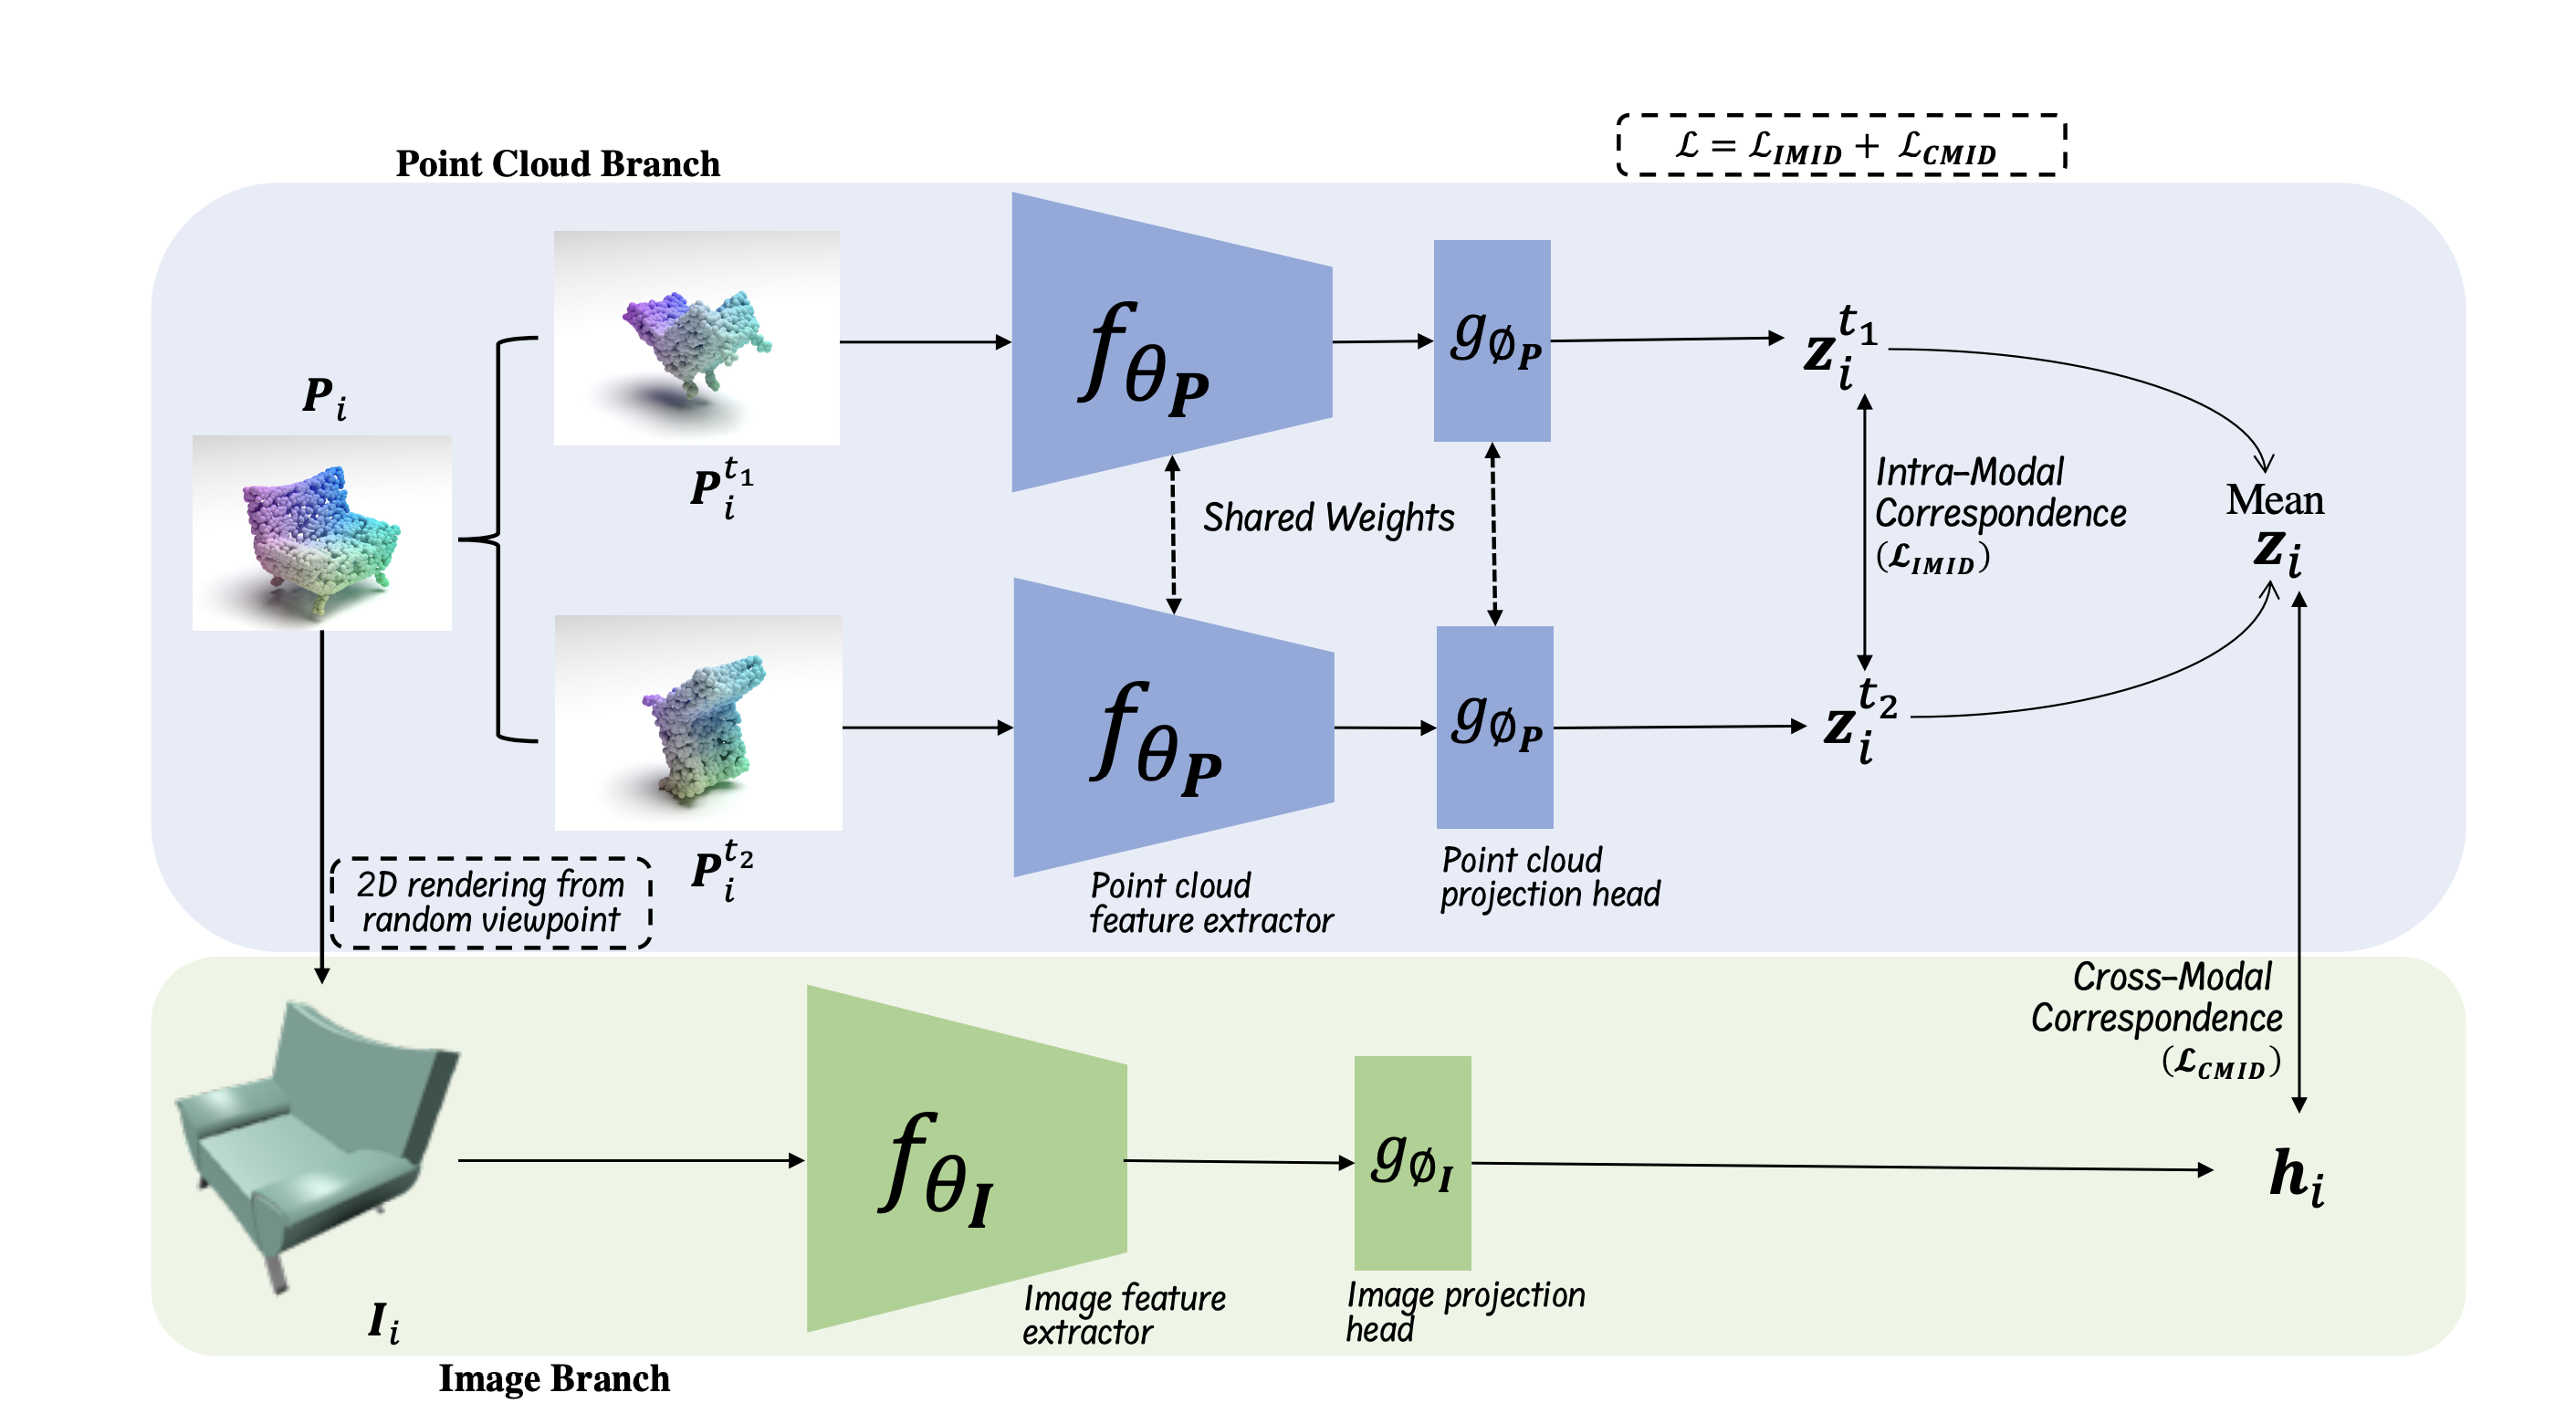

In [9]:
class CrosspointLightning (pl.LightningModule):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self._MODALITIES = ('3dPointCloud','Image')
        self.best_acc = 0
        self.validation_dataloader = self.args['validation_dataloader']

        if self.args['enable_wandb'] == True:
          self.wandb_log = {}


        print("Init Crosspoint Lightning")
        
        # ------------
        # models
        # ------------
        if args['model_point'] == 'dgcnn':
            self.point_model = DGCNN(args) 
        elif args['model_point'] == 'pct_naive':
            self.point_model = PCT_Naive(args) 
        elif args['model_point'] == 'pct_advanced':
            self.point_model = PCT_Advanced(args)           
        else:
            raise Exception("Not implemented")

        if args['model_img'] == 'resnet':
            self.img_model = ResNet(resnet50(), feat_dim = 2048) 
        elif args['model_img'] == 'visiontransformer':
            self.img_model = VisionTransformer(vit_l_16(pretrained=True), feat_dim = 1000) 
        else:
            raise Exception("Not implemented")

        
        self.criterion = NTXentLoss(temperature = 0.1)

        if args['enable_wandb'] == True:
            wandb.watch(self.point_model)

        if args['resume']:
            self.point_model = self.point_model.load_state_dict(torch.load(args['model_point_path']))
            self.img_model = self.img_model.load_state_dict(torch.load(args['model_img_path']))
            print("Model Loaded !!")

        if args['dataset_for_validation'] == 'Modelnet_Princeton':
          self.validation_dataloader = self.args['validation_dataloader']

        

    def on_train_epoch_start(self):
        print("Starting epoch ->",self.current_epoch)
        self.train_losses = AverageMeter()
        self.train_imid_losses = AverageMeter()
        self.train_cmid_losses = AverageMeter()

        self.point_model.train()
        self.img_model.train()

    def on_train_epoch_end(self):
      if self.args['enable_wandb'] == True:
          self.wandb_log['Train Loss'] = self.train_losses.avg
          self.wandb_log['Train IMID Loss'] = self.train_imid_losses.avg
          self.wandb_log['Train CMID Loss'] = self.train_cmid_losses.avg
          self.wandb_log['epoch'] = self.current_epoch

      print("Ending epoch ->",self.current_epoch)          
      outstr = 'Train %d, loss: %.6f' % (self.current_epoch, self.train_losses.avg)
      self.custom_validation_step(self.args)
      io.cprint(outstr)  
        
    def training_step(self, batch, batch_idx):
        (data_t1, data_t2) = batch[0]
        imgs = batch[1]
        #(data_t1 ,data_t2), imgs = batch
        batch_size = data_t1.size()[0]

        if args['model_point'] == 'dgcnn':
              data = torch.cat((data_t1, data_t2)) #data_t1,data_t2 shape -> [bs,2048,3]
              #data shape -> [2bs,2048,3]
              data = data.transpose(2, 1).contiguous() #data shape after transpose-> [2bs,3,2048]
              _, point_feats, _ = self.point_model(data) #point_feats shape-> [2bs,256]
              point_t1_feats = point_feats[:batch_size, :] #point_t1_feats shape-> [bs,256]
              point_t2_feats = point_feats[batch_size: , :] #point_t2_feats shape-> [bs,256]

              loss_imid = self.criterion(point_t1_feats, point_t2_feats)        
              point_feats = torch.stack([point_t1_feats,point_t2_feats]).mean(dim=0) #point_feats after mean shape-> [bs,256]
        elif args['model_point'] == 'pct_naive' or args['model_point'] == 'pct_advanced':
            data = torch.cat((data_t1, data_t2)) #data shape -> [2bs,2048,3]
            data = data.transpose(2, 1).contiguous() #data shape after transpose-> [2bs,3,2048]
            embbedded_x, _, _, _  = self.point_model(data) 
            point_t1_feats = embbedded_x[:batch_size, :]
            point_t2_feats = embbedded_x[batch_size: , :]
            loss_imid = self.criterion(point_t1_feats, point_t2_feats)        
            point_feats = torch.stack([point_t1_feats,point_t2_feats]).mean(dim=0)
        else:
            raise Exception("Not implemented")
        
        img_feats = self.img_model(imgs) #imgs_feats shape->[5,256]
        
        loss_cmid = self.criterion(point_feats, img_feats)

        total_loss = loss_imid + loss_cmid

        total_loss = loss_imid + loss_cmid
        
        #if self.args['enable_wandb'] == True:
        #  self.wandb_log['Total train loss'] = total_loss
        #  self.wandb_log['Total train imid loss'] = loss_imid
        #  self.wandb_log['Total train cmid loss'] = loss_cmid
        #  wandb.log(self.wandb_log)

        if batch_idx % self.args['print_freq'] == 0:
                print('Epoch (%d), Batch(%d/%d), loss: %.6f, imid loss: %.6f, cmid loss: %.6f ' % (self.current_epoch, batch_idx, self.args['train_loader_len'], total_loss, loss_imid, loss_cmid))
        

        self.train_losses.update(total_loss.item(), batch_size)
        self.train_imid_losses.update(loss_imid.item(), batch_size)
        self.train_cmid_losses.update(loss_cmid.item(), batch_size)
        
        return total_loss
    
    def custom_validation_step(self, args): #def custom_validation_step(self, x, args)
      print("Starting epoch ", self.current_epoch, " (validation_epoch_start)")

      if self.args['enable_MBT'] == False: 
        self.point_model.eval()
      else:
        self.MBT.eval()


      if self.args['enable_MBT'] == False:
        self.train_val_loader = DataLoader(ModelNet40SVM(partition='train', num_points=2048), num_workers=4, batch_size=self.args['validation_svm_batch_size_training'], shuffle=True)
        self.test_val_loader = DataLoader(ModelNet40SVM(partition='test', num_points=2048), num_workers=4, batch_size=self.args['validation_svm_batch_size_test'], shuffle=False)

        feats_train = []
        labels_train = []

        print("Starting epoch ", self.current_epoch, " (validation_step)")
        if torch.cuda.is_available():
          device = torch.device("cuda")
        else: device = torch.device('cpu')

        for i, (data, label) in enumerate(self.train_val_loader):
              labels = list(map(lambda x: x[0], label.numpy().tolist()))

              data = data.permute(0, 2, 1)
              
              data = data.to(device)
              
              with torch.no_grad():
                  if self.args['model_point'] == 'dgcnn':
                    feats = self.point_model(data)[2]
                  elif self.args['model_point'] == 'pct_naive' or self.args['model_point'] == 'pct_advanced':
                    feats = self.point_model(data)[3]
                  else:
                    raise ("Not implemented")
              
              feats = feats.detach().cpu().numpy()
              for feat in feats:
                  feats_train.append(feat)
              labels_train += labels

        feats_train = np.array(feats_train)
        labels_train = np.array(labels_train)

        feats_test = []
        labels_test = []

        for i, (data, label) in enumerate(self.test_val_loader):
          labels = list(map(lambda x: x[0],label.numpy().tolist()))

          data = data.permute(0, 2, 1)

          data = data.to(device)

          with torch.no_grad():
              if self.args['model_point'] == 'dgcnn':
                feats = self.point_model(data)[2]
              elif self.args['model_point'] == 'pct_naive' or self.args['model_point'] == 'pct_advanced':
                feats = self.point_model(data)[3]
              else:
                  raise NotImplementedError("Not implemented")


          feats = feats.detach().cpu().numpy()
          for feat in feats:
              feats_test.append(feat)
          labels_test += labels

        feats_test = np.array(feats_test)
        labels_test = np.array(labels_test)
        
        model_tl = SVC(C = 0.1, kernel ='linear')
        model_tl.fit(feats_train, labels_train)
        test_accuracy = model_tl.score(feats_test, labels_test)
        

      else: # ------ VALIDATION STEP FOR MBT MODEL --------
        val_size = len(x.dataset) #
        train_size = int(0.8 * val_size) #80%
        test_size = val_size - train_size #20%
        train_dataset, test_dataset = random_split(x.dataset, [train_size, test_size]) 

        #print("Validation size total = ",len(x.dataset)," train_size", train_size, "test_size", test_size)
        #print("Dimensioni degli split train_dataset = ",str(len(train_dataset)), " test_dataset=", len(test_dataset))

        
        train_val_loader = DataLoader(train_dataset, batch_size=self.args['validation_svm_batch_size_training'], shuffle=True, num_workers=4, drop_last=True) #BS 16
        test_val_loader = DataLoader(test_dataset, batch_size=self.args['validation_svm_batch_size_test'], shuffle=False, num_workers=4, drop_last=True) #BS 5
        
        #print("Dimensioni dei batch train_val_loader= ",str(len(train_val_loader)), " test_val_loader=", len(test_val_loader))

        batch_training = []

        for i, (data, img, img2, label) in enumerate(train_val_loader):
          data = data.to('cuda')
          img = img.to('cuda')

          label = list(label)

          with torch.no_grad():
              if self.args['use_cls_token'] == False:
                _, feats = self.MBT(data, img, testing=True, test_with_bottlenecks=args["test_with_bottlenecks"], training=False)
                feats = feats.detach().cpu().numpy()
                for i, feat in enumerate(feats):
                    element = (feat, label[i]) 
                    batch_training.append(element)
              else:
                z_cls_img, z_cls_t1, z_cls_t2, z_cls_pc, feats  = self.MBT(data,img,testing=True,test_with_bottlenecks=args["test_with_bottlenecks"])
              
                feats = feats.detach().cpu().numpy()
                for i, feat in enumerate(feats):
                    element = (feat,label[i]) 
                    batch_training.append(element)

        batch_test = []

        for i, (data, img, img2, label) in enumerate(test_val_loader):
          data = data.to('cuda')
          img = img.to('cuda')

          label = list(label)

          with torch.no_grad():
            if self.args['use_cls_token'] == False:
              _, feats= self.MBT(data,img,testing=True,test_with_bottlenecks=args["test_with_bottlenecks"], training=False)
              feats = feats.detach().cpu().numpy()
              for i, feat in enumerate(feats):
                  element = (feat, label[i]) 
                  batch_test.append(element)
            else:
              z_cls_img, z_cls_t1, z_cls_t2, z_cls_pc, feats  = self.MBT(data,img,testing=True,test_with_bottlenecks=args["test_with_bottlenecks"])
              
              feats = feats.detach().cpu().numpy()
              for i, feat in enumerate(feats):
                  element = (feat,label[i]) 
                  batch_test.append(element)

        if self.args['dataset_for_validation'] == "Shapenet":
          labels = ['table', 'jar', 'skateboard', 'car', 'bottle', 'tower', 'chair', 'bookshelf', 'camera', 'airplane', 'laptop', 'basket', 'sofa', 'knife', 'can', 'rifle', 'train', 'pillow', 'lamp', 'trash bin', 'mailbox', 'watercraft', 'motorbike', 'dishwasher', 'bench', 'pistol', 'rocket', 'loudspeaker', 'file cabinet', 'bag', 'cabinet', 'bed', 'birdhouse', 'display', 'piano', 'earphone', 'telephone', 'stove', 'microphone', 'bus', 'mug', 'remote', 'bathtub', 'bowl', 'keyboard', 'guitar', 'washer','bycicle','faucet','printer','cap']
        elif self.args['dataset_for_validation'] == "Modelnet":
          labels = ['airplane', 'bathtub', 'bed', 'bench', 'bookshelf', 'bottle', 'bowl', 'car', 'chair', 'cone', 'lamp', 'door', 'cup', 'desk', 'glass_box', 'curtain', 'guitar', 'dresser', 'flower_pot', 'keyboard', 'night_stand', 'monitor', 'mantel', 'person', 'sink', 'piano', 'range_hood', 'stairs', 'sofa', 'table', 'plant', 'tent', 'radio', 'stool', 'toilet', 'wardrobe', 'tv_stand', 'xbox', 'vase', 'laptop']
        else:
          raise Exception ("Dataset for validation is not recognized inn validation step in CrossPoint Module.")
          
        
        # Convert the first element of each tuple to a numpy array
        feats__train_array = np.array([t[0] for t in batch_training])
        feats__test_array = np.array([t[0] for t in batch_test])

        # Create a list of labels
        labels__train_list = [t[1] for t in batch_training]
        labels__test_list = [t[1] for t in batch_test]

        # Convert the labels to integers
        label_map = {l: i for i, l in enumerate(labels)}
        labels_train_int = [label_map[l] for l in labels__train_list]
        labels_test_int = [label_map[l] for l in labels__test_list]

        model_tl = SVC(C=0.1, kernel='linear')
        model_tl.fit(feats__train_array, labels_train_int)
        test_accuracy = model_tl.score(feats__test_array, labels_test_int)    

      if args['enable_wandb'] == True:
          self.wandb_log['Linear Accuracy'] = test_accuracy
          wandb.log(self.wandb_log)
      
      print(f"Linear Accuracy : {test_accuracy}")
  
      if test_accuracy > self.best_acc:
          self.best_acc = test_accuracy
          print('==> NEW RECORD on accuracy on epoch ',self.current_epoch,' --- Accuracy = ',test_accuracy,' ----> SAVING Best Model...') # Here I added /content/drive/MyDrive/VP_CrossPoint_2023/
          if self.args['enable_MBT'] == False:
            file_name = 'best_model'+self.args['model_point']+'.pth'
            save_file = os.path.join('/content/drive/MyDrive/VP_CrossPoint_2023/checkpoints/' + self.args['exp_name'] + '/models/', file_name.format(epoch=self.current_epoch) )
            torch.save(self.point_model.state_dict(), save_file)
          else: 
            file_name = 'best_model_MBT'+'.pth'
            save_file = os.path.join('/content/drive/MyDrive/VP_CrossPoint_2023/checkpoints/' + self.args['exp_name'] + '/models/', file_name.format(epoch=self.current_epoch) )
            torch.save(self.MBT.state_dict(), save_file)
          

          file_name = 'best_model'+self.args['model_img']+'.pth'
          save_img_model_file = os.path.join('/content/drive/MyDrive/VP_CrossPoint_2023/checkpoints/' + self.args['exp_name'] + '/models/', 'img_model_best'+self.args['model_img']+'.pth' )
          torch.save(self.img_model.state_dict(), save_img_model_file)

      if self.current_epoch % self.args['save_freq'] == 0:
          print('==> Saving for frequency...')
          if self.args['enable_MBT'] == False:
            save_file = os.path.join(f'/content/drive/MyDrive/VP_CrossPoint_2023/checkpoints/{self.args["exp_name"]}/models/','ckpt_epoch_{'+str(self.current_epoch)+'}'+self.args['model_point']+'.pth'.format(epoch=self.current_epoch))
            torch.save(self.point_model.state_dict(), save_file)
          else:
            save_file = os.path.join(f'/content/drive/MyDrive/VP_CrossPoint_2023/checkpoints/{self.args["exp_name"]}/models/','ckpt_epoch_{'+str(self.current_epoch)+'}_MBT'+'.pth'.format(epoch=self.current_epoch))
            torch.save(self.MBT.state_dict(), save_file)
             
      '''
      if args['enable_wandb'] == True:
        wandb.log(self.wandb_log)
      '''
      return {'val_acc': test_accuracy}

    def forward(self, x):
        return x

    def configure_optimizers(self):
        parameters = list(self.point_model.parameters()) + list(self.img_model.parameters())

        # ------------
        # optimizer
        # ------------
        if args['use_sgd']:
            print("Use SGD")
            optimizer = torch.optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'], weight_decay=1e-6)
        else:
            print("Use Adam")
            optimizer = torch.optim.Adam(parameters, lr=args['lr'], weight_decay=1e-6)
        
        # ------------
        # scheduler
        # ------------
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args['epochs'], eta_min=0, last_epoch=-1)


        return [optimizer], [lr_scheduler]

### THE TRAIN FUNCTION 🎉🎉🎉🎉

In [10]:
def train(args,io):

    if args['enable_wandb'] == True:
        print('Wandb Enabled')
        wandb.init(project="Visiope_Crosspoint", name=args['exp_name'], entity="sapienza_ml_2022_23", settings=wandb.Settings(code_dir="."))
        # wandb.run.log_code() # to save current code as an artifact in wandb # gets stuck here, why?
        wandb.config.update(args, allow_val_change=True)

    # ------------
    # data
    # ------------
    seed = 20
    generator = torch.Generator().manual_seed(seed)

    transform = transforms.Compose([transforms.Resize((224, 224)),
                                    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(), 
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
    if args['dataset_for_validation'] == 'Modelnet_Crosspoint':
      print("Enabled for validation ->",args['dataset_for_validation'])
      train_loader = DataLoader(ShapeNetRender_for_CrossPoint(transform, n_imgs = 2, exclusion_list=args['exclusion_list_shapenet']), num_workers=12, batch_size=args['batch_size'], shuffle=True, drop_last=True)
      args['train_loader_len'] = len(train_loader)

      print("Enabled for validation ->",args['dataset_for_validation'])
      validation_dataset = ModelNet40SVM(partition='test', num_points=2048)
      validation_size = int(0.6 * len(validation_dataset))
      test_size = len(validation_dataset) - validation_size
      validation_set , test_set = random_split( validation_dataset, [validation_size, test_size], generator=generator) #Here we discard the test setwtf
      validation_loader = DataLoader(validation_set, batch_size=args['val_batch_size'], shuffle=True, num_workers=4, generator=generator, drop_last=True)
      print("You have: ",len(train_loader)," batches for training, ",len(validation_loader)," batches for validation")
          
    else:
      raise Exception("Something wrong in choosing dataset_for_validation parameter , you must choose between Modelnet_Crosspoint and Modelnet_Princeton")
    
  
    args['train_loader_len'] = len(train_loader)
    args['validation_dataloader'] = validation_loader
    args['val_loader_len'] = len(validation_loader)
    # ------------
    # model
    # ------------
    model = CrosspointLightning(args)

    # ------------
    # training
    # ------------
    parsed_args = argparse.Namespace(**args)

    trainer = pl.Trainer.from_argparse_args(parsed_args,max_epochs=args['epochs'],accelerator='gpu', devices=1)

    trainer.fit(model, train_loader)

### 🚀🚀🚀🚀 THE MAIN FUNCTION 🚀🚀🚀🚀

In [11]:
check_checkpoint_folders()
io = IOStream('/content/drive/MyDrive/VP_CrossPoint_2023/checkpoints/' + args['exp_name'] + '/run.log')
io.cprint(str(args))
args['cuda'] = not args['no_cuda'] and torch.cuda.is_available()
torch.manual_seed(args['seed'])
if args['cuda']:
    io.cprint(
        'Using GPU : ' + str(torch.cuda.current_device()) + ' from ' + str(torch.cuda.device_count()) + ' devices')
    torch.cuda.manual_seed(args['seed'])
else:
    io.cprint('Using CPU')

sys.path.append('/content/drive/MyDrive/VP_CrossPoint_2023/datasets')
from drive.MyDrive.VP_CrossPoint_2023.datasets.data import ShapeNetRender_for_CrossPoint, ModelNet40SVM, ModelNet40SVM_MBT


# ------------
# training or testing
# ------------ 
if not args['evalu']:
    train(args, io)

{'exp_name': 'dgcnn+Resnet', 'model_point': 'dgcnn', 'model_img': 'resnet', 'batch_size': 15, 'val_batch_size': 2, 'test_batch_size': 2, 'epochs': 20, 'start_epoch': 0, 'use_sgd': False, 'lr': 0.001, 'momentum': 0.9, 'no_cuda': False, 'seed': 1, 'evalu': False, 'num_points': 2048, 'dropout': 0.5, 'emb_dims': 1024, 'k': 20, 'resume': False, 'model_point_path': '', 'model_img_path': '', 'save_freq': 2, 'print_freq': 2, 'enable_wandb': True, 'dataset_for_validation': 'Modelnet_Crosspoint', 'exclusion_list_shapenet': ['02828884', '04256520', '03691459', '04379243', '04090263', '03001627', '03636649', '02958343'], 'exclusion_list_modelnet': [], 'validation_svm_batch_size_training': 16, 'validation_svm_batch_size_test': 5, 'enable_MBT': False}
Using GPU : 0 from 1 devices
Wandb Enabled


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Enabled for validation -> Modelnet_Crosspoint
Listdir base dir:  ['data', 'datasets', 'Pointnet2_PyTorch', 'eval_ssl.ipynb', 'V13.2_train_custom_lightning.ipynb', 'util.py', '__pycache__', 'checkpoints', 'V1.0_Crosspoint_Lightning.ipynb', 'V1_Crosspoint_Lightning.ipynb', 'Configurazione modelli.gsheet', 'V2_Crosspoint_Lightning.ipynb']
Data dir: ./drive/MyDrive/VP_CrossPoint_2023/data
classes dir: ['./drive/MyDrive/VP_CrossPoint_2023/data/ShapeNet/02691156', './drive/MyDrive/VP_CrossPoint_2023/data/ShapeNet/02933112', './drive/MyDrive/VP_CrossPoint_2023/data/ShapeNet/03211117', './drive/MyDrive/VP_CrossPoint_2023/data/ShapeNet/04401088', './drive/MyDrive/VP_CrossPoint_2023/data/ShapeNet/02828884', './drive/MyDrive/VP_CrossPoint_2023/data/ShapeNet/04256520', './drive/MyDrive/VP_CrossPoint_2023/data/ShapeNet/04530566', './drive/MyDrive/VP_CrossPoint_2023/data/ShapeNet/03691459', './drive/MyDrive/VP_CrossPoint_2023/data/ShapeNet/04379243', './drive/MyDrive/VP_CrossPoint_2023/data/ShapeNet

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


You have:  646  batches for training,  740  batches for validation
Init Crosspoint Lightning


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type       | Params
-------------------------------------------
0 | point_model | DGCNN      | 3.0 M 
1 | img_model   | ResNet     | 24.7 M
2 | criterion   | NTXentLoss | 0     
-------------------------------------------
27.7 M    Trainable params
0         Non-trainable params
27.7 M    Total params
110.677   Total estimated model params size (MB)


Use Adam


Training: 0it [00:00, ?it/s]

Starting epoch -> 0


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (0), Batch(0/646), loss: 11.709981, imid loss: 3.948800, cmid loss: 7.761181 
Epoch (0), Batch(2/646), loss: 8.149569, imid loss: 3.524213, cmid loss: 4.625355 
Epoch (0), Batch(4/646), loss: 7.303041, imid loss: 3.596456, cmid loss: 3.706586 
Epoch (0), Batch(6/646), loss: 6.682098, imid loss: 3.220001, cmid loss: 3.462097 
Epoch (0), Batch(8/646), loss: 6.676373, imid loss: 3.261691, cmid loss: 3.414682 
Epoch (0), Batch(10/646), loss: 6.780722, imid loss: 3.344118, cmid loss: 3.436604 
Epoch (0), Batch(12/646), loss: 6.679335, imid loss: 3.254664, cmid loss: 3.424671 
Epoch (0), Batch(14/646), loss: 6.717824, imid loss: 3.301903, cmid loss: 3.415921 
Epoch (0), Batch(16/646), loss: 6.678447, imid loss: 3.271293, cmid loss: 3.407153 
Epoch (0), Batch(18/646), loss: 6.652021, imid loss: 3.267688, cmid loss: 3.384333 
Epoch (0), Batch(20/646), loss: 6.613477, imid loss: 3.243213, cmid loss: 3.370264 
Epoch (0), Batch(22/646), loss: 6.530983, imid loss: 3.155268, cmid loss: 3.3757

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (1), Batch(0/646), loss: 3.916883, imid loss: 1.746930, cmid loss: 2.169953 
Epoch (1), Batch(2/646), loss: 4.348830, imid loss: 1.729508, cmid loss: 2.619322 
Epoch (1), Batch(4/646), loss: 4.183898, imid loss: 1.848185, cmid loss: 2.335713 
Epoch (1), Batch(6/646), loss: 4.324609, imid loss: 1.883903, cmid loss: 2.440706 
Epoch (1), Batch(8/646), loss: 3.877645, imid loss: 1.696300, cmid loss: 2.181345 
Epoch (1), Batch(10/646), loss: 4.339731, imid loss: 2.286633, cmid loss: 2.053098 
Epoch (1), Batch(12/646), loss: 4.511921, imid loss: 1.841805, cmid loss: 2.670116 
Epoch (1), Batch(14/646), loss: 3.815918, imid loss: 1.652767, cmid loss: 2.163151 
Epoch (1), Batch(16/646), loss: 4.286587, imid loss: 1.601007, cmid loss: 2.685580 
Epoch (1), Batch(18/646), loss: 3.516244, imid loss: 1.587534, cmid loss: 1.928710 
Epoch (1), Batch(20/646), loss: 3.885436, imid loss: 1.697156, cmid loss: 2.188281 
Epoch (1), Batch(22/646), loss: 4.048216, imid loss: 1.612561, cmid loss: 2.43565

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (2), Batch(0/646), loss: 3.106860, imid loss: 1.381186, cmid loss: 1.725674 
Epoch (2), Batch(2/646), loss: 2.726134, imid loss: 1.064637, cmid loss: 1.661497 
Epoch (2), Batch(4/646), loss: 2.873198, imid loss: 1.174708, cmid loss: 1.698490 
Epoch (2), Batch(6/646), loss: 3.750861, imid loss: 1.615668, cmid loss: 2.135194 
Epoch (2), Batch(8/646), loss: 3.428400, imid loss: 1.324373, cmid loss: 2.104026 
Epoch (2), Batch(10/646), loss: 3.117256, imid loss: 0.709940, cmid loss: 2.407316 
Epoch (2), Batch(12/646), loss: 2.782875, imid loss: 1.056624, cmid loss: 1.726251 
Epoch (2), Batch(14/646), loss: 3.900882, imid loss: 1.310177, cmid loss: 2.590705 
Epoch (2), Batch(16/646), loss: 2.490163, imid loss: 0.918728, cmid loss: 1.571436 
Epoch (2), Batch(18/646), loss: 3.300256, imid loss: 1.144537, cmid loss: 2.155719 
Epoch (2), Batch(20/646), loss: 3.059584, imid loss: 1.068149, cmid loss: 1.991435 
Epoch (2), Batch(22/646), loss: 3.585040, imid loss: 1.218527, cmid loss: 2.36651

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (3), Batch(0/646), loss: 3.529139, imid loss: 1.068388, cmid loss: 2.460751 
Epoch (3), Batch(2/646), loss: 3.320301, imid loss: 1.104107, cmid loss: 2.216193 
Epoch (3), Batch(4/646), loss: 2.869492, imid loss: 0.769580, cmid loss: 2.099912 
Epoch (3), Batch(6/646), loss: 3.796590, imid loss: 1.248266, cmid loss: 2.548324 
Epoch (3), Batch(8/646), loss: 3.173774, imid loss: 0.682149, cmid loss: 2.491624 
Epoch (3), Batch(10/646), loss: 3.314279, imid loss: 1.209727, cmid loss: 2.104553 
Epoch (3), Batch(12/646), loss: 3.852771, imid loss: 1.208068, cmid loss: 2.644702 
Epoch (3), Batch(14/646), loss: 3.374130, imid loss: 1.126488, cmid loss: 2.247642 
Epoch (3), Batch(16/646), loss: 2.990873, imid loss: 0.959410, cmid loss: 2.031462 
Epoch (3), Batch(18/646), loss: 3.790827, imid loss: 0.896112, cmid loss: 2.894715 
Epoch (3), Batch(20/646), loss: 2.509873, imid loss: 0.794059, cmid loss: 1.715814 
Epoch (3), Batch(22/646), loss: 2.775686, imid loss: 0.736439, cmid loss: 2.03924

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (4), Batch(0/646), loss: 2.552255, imid loss: 0.705021, cmid loss: 1.847234 
Epoch (4), Batch(2/646), loss: 2.322940, imid loss: 0.755747, cmid loss: 1.567193 
Epoch (4), Batch(4/646), loss: 2.230464, imid loss: 0.777482, cmid loss: 1.452982 
Epoch (4), Batch(6/646), loss: 3.433604, imid loss: 1.186384, cmid loss: 2.247221 
Epoch (4), Batch(8/646), loss: 2.068349, imid loss: 0.831934, cmid loss: 1.236415 
Epoch (4), Batch(10/646), loss: 2.552325, imid loss: 0.559193, cmid loss: 1.993131 
Epoch (4), Batch(12/646), loss: 3.322338, imid loss: 1.092103, cmid loss: 2.230235 
Epoch (4), Batch(14/646), loss: 2.384050, imid loss: 0.741321, cmid loss: 1.642729 
Epoch (4), Batch(16/646), loss: 2.648115, imid loss: 0.902796, cmid loss: 1.745320 
Epoch (4), Batch(18/646), loss: 3.218493, imid loss: 1.081078, cmid loss: 2.137416 
Epoch (4), Batch(20/646), loss: 2.045299, imid loss: 0.736329, cmid loss: 1.308970 
Epoch (4), Batch(22/646), loss: 2.874176, imid loss: 0.873992, cmid loss: 2.00018

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (5), Batch(0/646), loss: 2.765512, imid loss: 1.014081, cmid loss: 1.751431 
Epoch (5), Batch(2/646), loss: 2.570030, imid loss: 0.909743, cmid loss: 1.660287 
Epoch (5), Batch(4/646), loss: 2.372994, imid loss: 0.358189, cmid loss: 2.014805 
Epoch (5), Batch(6/646), loss: 2.107304, imid loss: 0.679007, cmid loss: 1.428297 
Epoch (5), Batch(8/646), loss: 1.606133, imid loss: 0.494806, cmid loss: 1.111327 
Epoch (5), Batch(10/646), loss: 1.930721, imid loss: 0.717298, cmid loss: 1.213423 
Epoch (5), Batch(12/646), loss: 2.338793, imid loss: 0.464906, cmid loss: 1.873887 
Epoch (5), Batch(14/646), loss: 2.862894, imid loss: 0.660883, cmid loss: 2.202010 
Epoch (5), Batch(16/646), loss: 2.673079, imid loss: 0.710992, cmid loss: 1.962087 
Epoch (5), Batch(18/646), loss: 1.840644, imid loss: 0.473338, cmid loss: 1.367306 
Epoch (5), Batch(20/646), loss: 1.868137, imid loss: 0.615550, cmid loss: 1.252587 
Epoch (5), Batch(22/646), loss: 2.303471, imid loss: 0.734384, cmid loss: 1.56908

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (6), Batch(0/646), loss: 1.653184, imid loss: 0.365184, cmid loss: 1.288000 
Epoch (6), Batch(2/646), loss: 3.114976, imid loss: 0.973965, cmid loss: 2.141011 
Epoch (6), Batch(4/646), loss: 2.125308, imid loss: 0.542613, cmid loss: 1.582695 
Epoch (6), Batch(6/646), loss: 2.750193, imid loss: 0.459312, cmid loss: 2.290882 
Epoch (6), Batch(8/646), loss: 2.577187, imid loss: 0.634533, cmid loss: 1.942654 
Epoch (6), Batch(10/646), loss: 1.481928, imid loss: 0.375907, cmid loss: 1.106022 
Epoch (6), Batch(12/646), loss: 2.224927, imid loss: 0.890639, cmid loss: 1.334288 
Epoch (6), Batch(14/646), loss: 3.348972, imid loss: 0.845585, cmid loss: 2.503388 
Epoch (6), Batch(16/646), loss: 2.395985, imid loss: 0.588562, cmid loss: 1.807422 
Epoch (6), Batch(18/646), loss: 2.854521, imid loss: 1.383093, cmid loss: 1.471428 
Epoch (6), Batch(20/646), loss: 2.065649, imid loss: 0.726049, cmid loss: 1.339599 
Epoch (6), Batch(22/646), loss: 2.980615, imid loss: 1.135181, cmid loss: 1.84543

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (7), Batch(0/646), loss: 2.711394, imid loss: 0.756456, cmid loss: 1.954938 
Epoch (7), Batch(2/646), loss: 1.809005, imid loss: 0.497228, cmid loss: 1.311777 
Epoch (7), Batch(4/646), loss: 1.828114, imid loss: 0.756280, cmid loss: 1.071834 
Epoch (7), Batch(6/646), loss: 2.513291, imid loss: 0.888387, cmid loss: 1.624905 
Epoch (7), Batch(8/646), loss: 2.077419, imid loss: 0.422351, cmid loss: 1.655069 
Epoch (7), Batch(10/646), loss: 2.956778, imid loss: 0.396701, cmid loss: 2.560077 
Epoch (7), Batch(12/646), loss: 1.671620, imid loss: 0.570207, cmid loss: 1.101413 
Epoch (7), Batch(14/646), loss: 2.864135, imid loss: 0.965363, cmid loss: 1.898771 
Epoch (7), Batch(16/646), loss: 2.748952, imid loss: 0.754685, cmid loss: 1.994267 
Epoch (7), Batch(18/646), loss: 2.071852, imid loss: 0.487145, cmid loss: 1.584706 
Epoch (7), Batch(20/646), loss: 1.899885, imid loss: 0.444352, cmid loss: 1.455532 
Epoch (7), Batch(22/646), loss: 2.370537, imid loss: 0.732612, cmid loss: 1.63792

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (8), Batch(0/646), loss: 2.547764, imid loss: 0.741287, cmid loss: 1.806476 
Epoch (8), Batch(2/646), loss: 1.900177, imid loss: 0.529698, cmid loss: 1.370479 
Epoch (8), Batch(4/646), loss: 1.980553, imid loss: 0.562687, cmid loss: 1.417865 
Epoch (8), Batch(6/646), loss: 1.707359, imid loss: 0.420799, cmid loss: 1.286559 
Epoch (8), Batch(8/646), loss: 1.802189, imid loss: 0.553743, cmid loss: 1.248446 
Epoch (8), Batch(10/646), loss: 0.936931, imid loss: 0.213723, cmid loss: 0.723208 
Epoch (8), Batch(12/646), loss: 1.817711, imid loss: 0.413337, cmid loss: 1.404374 
Epoch (8), Batch(14/646), loss: 1.852187, imid loss: 0.449778, cmid loss: 1.402409 
Epoch (8), Batch(16/646), loss: 2.750419, imid loss: 0.819841, cmid loss: 1.930578 
Epoch (8), Batch(18/646), loss: 1.625854, imid loss: 0.480351, cmid loss: 1.145503 
Epoch (8), Batch(20/646), loss: 2.375580, imid loss: 0.846999, cmid loss: 1.528580 
Epoch (8), Batch(22/646), loss: 1.794612, imid loss: 0.680348, cmid loss: 1.11426

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (9), Batch(0/646), loss: 1.351140, imid loss: 0.256525, cmid loss: 1.094615 
Epoch (9), Batch(2/646), loss: 1.882194, imid loss: 0.727038, cmid loss: 1.155155 
Epoch (9), Batch(4/646), loss: 2.148846, imid loss: 0.866082, cmid loss: 1.282764 
Epoch (9), Batch(6/646), loss: 1.669417, imid loss: 0.606324, cmid loss: 1.063093 
Epoch (9), Batch(8/646), loss: 2.226018, imid loss: 0.622418, cmid loss: 1.603600 
Epoch (9), Batch(10/646), loss: 2.338278, imid loss: 0.749515, cmid loss: 1.588763 
Epoch (9), Batch(12/646), loss: 1.071385, imid loss: 0.415431, cmid loss: 0.655954 
Epoch (9), Batch(14/646), loss: 1.404740, imid loss: 0.568241, cmid loss: 0.836499 
Epoch (9), Batch(16/646), loss: 1.899176, imid loss: 0.564359, cmid loss: 1.334817 
Epoch (9), Batch(18/646), loss: 2.131174, imid loss: 0.734367, cmid loss: 1.396807 
Epoch (9), Batch(20/646), loss: 1.964985, imid loss: 0.715481, cmid loss: 1.249504 
Epoch (9), Batch(22/646), loss: 1.320809, imid loss: 0.409838, cmid loss: 0.91097

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (10), Batch(0/646), loss: 2.020332, imid loss: 0.567060, cmid loss: 1.453273 
Epoch (10), Batch(2/646), loss: 1.680682, imid loss: 0.636796, cmid loss: 1.043885 
Epoch (10), Batch(4/646), loss: 1.639526, imid loss: 0.729179, cmid loss: 0.910347 
Epoch (10), Batch(6/646), loss: 1.143829, imid loss: 0.409084, cmid loss: 0.734745 
Epoch (10), Batch(8/646), loss: 1.684435, imid loss: 0.479395, cmid loss: 1.205040 
Epoch (10), Batch(10/646), loss: 1.370231, imid loss: 0.575089, cmid loss: 0.795142 
Epoch (10), Batch(12/646), loss: 2.240152, imid loss: 0.832317, cmid loss: 1.407835 
Epoch (10), Batch(14/646), loss: 1.308537, imid loss: 0.408865, cmid loss: 0.899672 
Epoch (10), Batch(16/646), loss: 2.533000, imid loss: 0.624151, cmid loss: 1.908849 
Epoch (10), Batch(18/646), loss: 1.619305, imid loss: 0.483155, cmid loss: 1.136150 
Epoch (10), Batch(20/646), loss: 1.994786, imid loss: 0.799300, cmid loss: 1.195486 
Epoch (10), Batch(22/646), loss: 1.426542, imid loss: 0.176658, cmid l

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (11), Batch(0/646), loss: 1.861950, imid loss: 0.606873, cmid loss: 1.255078 
Epoch (11), Batch(2/646), loss: 1.948275, imid loss: 0.660673, cmid loss: 1.287602 
Epoch (11), Batch(4/646), loss: 0.779482, imid loss: 0.204676, cmid loss: 0.574806 
Epoch (11), Batch(6/646), loss: 1.671510, imid loss: 0.143186, cmid loss: 1.528324 
Epoch (11), Batch(8/646), loss: 1.438130, imid loss: 0.376674, cmid loss: 1.061456 
Epoch (11), Batch(10/646), loss: 1.760089, imid loss: 0.552380, cmid loss: 1.207708 
Epoch (11), Batch(12/646), loss: 2.165471, imid loss: 0.804838, cmid loss: 1.360633 
Epoch (11), Batch(14/646), loss: 1.556345, imid loss: 0.637949, cmid loss: 0.918396 
Epoch (11), Batch(16/646), loss: 1.959882, imid loss: 0.590414, cmid loss: 1.369468 
Epoch (11), Batch(18/646), loss: 1.348895, imid loss: 0.179002, cmid loss: 1.169893 
Epoch (11), Batch(20/646), loss: 1.002290, imid loss: 0.342155, cmid loss: 0.660136 
Epoch (11), Batch(22/646), loss: 2.058104, imid loss: 0.775798, cmid l

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (12), Batch(0/646), loss: 0.902200, imid loss: 0.334458, cmid loss: 0.567741 
Epoch (12), Batch(2/646), loss: 1.796167, imid loss: 0.236541, cmid loss: 1.559626 
Epoch (12), Batch(4/646), loss: 1.825718, imid loss: 0.443525, cmid loss: 1.382193 
Epoch (12), Batch(6/646), loss: 1.144045, imid loss: 0.524013, cmid loss: 0.620032 
Epoch (12), Batch(8/646), loss: 1.191814, imid loss: 0.292137, cmid loss: 0.899677 
Epoch (12), Batch(10/646), loss: 1.597376, imid loss: 0.391465, cmid loss: 1.205911 
Epoch (12), Batch(12/646), loss: 1.736021, imid loss: 0.566288, cmid loss: 1.169733 
Epoch (12), Batch(14/646), loss: 0.980697, imid loss: 0.214985, cmid loss: 0.765712 
Epoch (12), Batch(16/646), loss: 2.519412, imid loss: 1.197786, cmid loss: 1.321626 
Epoch (12), Batch(18/646), loss: 1.247484, imid loss: 0.475334, cmid loss: 0.772150 
Epoch (12), Batch(20/646), loss: 1.165203, imid loss: 0.256016, cmid loss: 0.909187 
Epoch (12), Batch(22/646), loss: 1.932972, imid loss: 0.892334, cmid l

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (13), Batch(0/646), loss: 1.146056, imid loss: 0.462471, cmid loss: 0.683585 
Epoch (13), Batch(2/646), loss: 1.215368, imid loss: 0.368757, cmid loss: 0.846611 
Epoch (13), Batch(4/646), loss: 2.181661, imid loss: 0.511561, cmid loss: 1.670100 
Epoch (13), Batch(6/646), loss: 0.869822, imid loss: 0.285535, cmid loss: 0.584287 
Epoch (13), Batch(8/646), loss: 2.303729, imid loss: 0.809641, cmid loss: 1.494087 
Epoch (13), Batch(10/646), loss: 1.557182, imid loss: 0.378629, cmid loss: 1.178553 
Epoch (13), Batch(12/646), loss: 1.492998, imid loss: 0.535015, cmid loss: 0.957983 
Epoch (13), Batch(14/646), loss: 0.879014, imid loss: 0.114321, cmid loss: 0.764693 
Epoch (13), Batch(16/646), loss: 0.747404, imid loss: 0.246571, cmid loss: 0.500832 
Epoch (13), Batch(18/646), loss: 1.669242, imid loss: 0.524771, cmid loss: 1.144471 
Epoch (13), Batch(20/646), loss: 1.780695, imid loss: 0.380534, cmid loss: 1.400161 
Epoch (13), Batch(22/646), loss: 0.838626, imid loss: 0.143635, cmid l

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (14), Batch(0/646), loss: 2.184719, imid loss: 0.705863, cmid loss: 1.478856 
Epoch (14), Batch(2/646), loss: 1.686721, imid loss: 0.692600, cmid loss: 0.994121 
Epoch (14), Batch(4/646), loss: 1.420884, imid loss: 0.356651, cmid loss: 1.064233 
Epoch (14), Batch(6/646), loss: 0.643274, imid loss: 0.236045, cmid loss: 0.407229 
Epoch (14), Batch(8/646), loss: 1.720265, imid loss: 0.364962, cmid loss: 1.355303 
Epoch (14), Batch(10/646), loss: 1.183926, imid loss: 0.381094, cmid loss: 0.802832 
Epoch (14), Batch(12/646), loss: 1.494583, imid loss: 0.534457, cmid loss: 0.960126 
Epoch (14), Batch(14/646), loss: 1.296376, imid loss: 0.186225, cmid loss: 1.110151 
Epoch (14), Batch(16/646), loss: 0.747770, imid loss: 0.170616, cmid loss: 0.577154 
Epoch (14), Batch(18/646), loss: 1.475951, imid loss: 0.299163, cmid loss: 1.176787 
Epoch (14), Batch(20/646), loss: 0.799439, imid loss: 0.249494, cmid loss: 0.549945 
Epoch (14), Batch(22/646), loss: 1.734298, imid loss: 0.445954, cmid l

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (15), Batch(0/646), loss: 1.055510, imid loss: 0.373867, cmid loss: 0.681643 
Epoch (15), Batch(2/646), loss: 1.541863, imid loss: 0.545058, cmid loss: 0.996805 
Epoch (15), Batch(4/646), loss: 1.128400, imid loss: 0.405306, cmid loss: 0.723093 
Epoch (15), Batch(6/646), loss: 0.820906, imid loss: 0.254783, cmid loss: 0.566123 
Epoch (15), Batch(8/646), loss: 1.047804, imid loss: 0.353769, cmid loss: 0.694035 
Epoch (15), Batch(10/646), loss: 1.211505, imid loss: 0.512976, cmid loss: 0.698529 
Epoch (15), Batch(12/646), loss: 0.899696, imid loss: 0.334676, cmid loss: 0.565019 
Epoch (15), Batch(14/646), loss: 1.009694, imid loss: 0.274761, cmid loss: 0.734933 
Epoch (15), Batch(16/646), loss: 0.815232, imid loss: 0.287082, cmid loss: 0.528150 
Epoch (15), Batch(18/646), loss: 1.216470, imid loss: 0.379711, cmid loss: 0.836759 
Epoch (15), Batch(20/646), loss: 1.697714, imid loss: 0.387300, cmid loss: 1.310414 
Epoch (15), Batch(22/646), loss: 1.449680, imid loss: 0.432703, cmid l

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (16), Batch(0/646), loss: 1.384723, imid loss: 0.428924, cmid loss: 0.955799 
Epoch (16), Batch(2/646), loss: 1.765322, imid loss: 0.657592, cmid loss: 1.107730 
Epoch (16), Batch(4/646), loss: 0.478283, imid loss: 0.078477, cmid loss: 0.399806 
Epoch (16), Batch(6/646), loss: 1.108703, imid loss: 0.128198, cmid loss: 0.980505 
Epoch (16), Batch(8/646), loss: 0.941070, imid loss: 0.234148, cmid loss: 0.706922 
Epoch (16), Batch(10/646), loss: 1.253913, imid loss: 0.299599, cmid loss: 0.954314 
Epoch (16), Batch(12/646), loss: 1.677867, imid loss: 0.380943, cmid loss: 1.296925 
Epoch (16), Batch(14/646), loss: 1.964421, imid loss: 0.552481, cmid loss: 1.411940 
Epoch (16), Batch(16/646), loss: 1.120729, imid loss: 0.354231, cmid loss: 0.766498 
Epoch (16), Batch(18/646), loss: 0.889777, imid loss: 0.237485, cmid loss: 0.652292 
Epoch (16), Batch(20/646), loss: 1.240589, imid loss: 0.476256, cmid loss: 0.764333 
Epoch (16), Batch(22/646), loss: 0.852024, imid loss: 0.166215, cmid l

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (17), Batch(0/646), loss: 0.755028, imid loss: 0.253211, cmid loss: 0.501817 
Epoch (17), Batch(2/646), loss: 1.091395, imid loss: 0.294039, cmid loss: 0.797356 
Epoch (17), Batch(4/646), loss: 0.741417, imid loss: 0.213764, cmid loss: 0.527653 
Epoch (17), Batch(6/646), loss: 1.101820, imid loss: 0.349065, cmid loss: 0.752756 
Epoch (17), Batch(8/646), loss: 1.322025, imid loss: 0.402169, cmid loss: 0.919857 
Epoch (17), Batch(10/646), loss: 1.104810, imid loss: 0.336778, cmid loss: 0.768032 
Epoch (17), Batch(12/646), loss: 0.925690, imid loss: 0.227367, cmid loss: 0.698323 
Epoch (17), Batch(14/646), loss: 1.708040, imid loss: 0.505898, cmid loss: 1.202142 
Epoch (17), Batch(16/646), loss: 1.555164, imid loss: 0.378677, cmid loss: 1.176486 
Epoch (17), Batch(18/646), loss: 1.470985, imid loss: 0.232989, cmid loss: 1.237996 
Epoch (17), Batch(20/646), loss: 1.583863, imid loss: 0.689211, cmid loss: 0.894652 
Epoch (17), Batch(22/646), loss: 0.632545, imid loss: 0.194977, cmid l

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (18), Batch(0/646), loss: 1.002061, imid loss: 0.301338, cmid loss: 0.700723 
Epoch (18), Batch(2/646), loss: 0.758349, imid loss: 0.249635, cmid loss: 0.508714 
Epoch (18), Batch(4/646), loss: 0.911632, imid loss: 0.279657, cmid loss: 0.631975 
Epoch (18), Batch(6/646), loss: 0.747837, imid loss: 0.154093, cmid loss: 0.593744 
Epoch (18), Batch(8/646), loss: 1.451141, imid loss: 0.515374, cmid loss: 0.935767 
Epoch (18), Batch(10/646), loss: 1.218942, imid loss: 0.376864, cmid loss: 0.842078 
Epoch (18), Batch(12/646), loss: 1.720490, imid loss: 0.587238, cmid loss: 1.133253 
Epoch (18), Batch(14/646), loss: 1.037322, imid loss: 0.225573, cmid loss: 0.811749 
Epoch (18), Batch(16/646), loss: 0.971954, imid loss: 0.132301, cmid loss: 0.839653 
Epoch (18), Batch(18/646), loss: 1.382004, imid loss: 0.383676, cmid loss: 0.998328 
Epoch (18), Batch(20/646), loss: 1.212594, imid loss: 0.226997, cmid loss: 0.985597 
Epoch (18), Batch(22/646), loss: 0.997117, imid loss: 0.174736, cmid l

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (19), Batch(0/646), loss: 1.370507, imid loss: 0.418942, cmid loss: 0.951565 
Epoch (19), Batch(2/646), loss: 1.556461, imid loss: 0.644637, cmid loss: 0.911824 
Epoch (19), Batch(4/646), loss: 1.187276, imid loss: 0.457257, cmid loss: 0.730019 
Epoch (19), Batch(6/646), loss: 1.390760, imid loss: 0.444645, cmid loss: 0.946115 
Epoch (19), Batch(8/646), loss: 1.280606, imid loss: 0.527399, cmid loss: 0.753207 
Epoch (19), Batch(10/646), loss: 1.377310, imid loss: 0.344713, cmid loss: 1.032596 
Epoch (19), Batch(12/646), loss: 1.519648, imid loss: 0.257609, cmid loss: 1.262039 
Epoch (19), Batch(14/646), loss: 0.820130, imid loss: 0.335621, cmid loss: 0.484510 
Epoch (19), Batch(16/646), loss: 0.931363, imid loss: 0.336217, cmid loss: 0.595147 
Epoch (19), Batch(18/646), loss: 1.258016, imid loss: 0.415813, cmid loss: 0.842204 
Epoch (19), Batch(20/646), loss: 1.325041, imid loss: 0.363927, cmid loss: 0.961114 
Epoch (19), Batch(22/646), loss: 1.142180, imid loss: 0.390715, cmid l

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Linear Accuracy : 0.8780388978930308
Train 19, loss: 1.075346
